In [3]:
#!sudo pip install pymc3
import pymc3 as pm
import pandas as pd 
import numpy as np
import psycopg2 
import os
import json
from tpot import TPOTClassifier
from sklearn.metrics import classification_report

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
conn = psycopg2.connect(
    user = os.environ['REDSHIFT_USER']
    ,password = os.environ['REDSHIFT_PASS']    
    ,port = os.environ['REDSHIFT_PORT']
    ,host = os.environ['REDSHIFT_HOST']
    ,database = 'tradesy'
)
query = """
    select 
        purchase_dummy
        ,shipping_price_ratio
        ,asking_price
        ,price_level
        ,brand_score
        ,brand_size
        ,a_over_b
        ,favorite_count
        ,has_blurb
        ,has_image
        ,seasonal_component
        ,description_length
        ,product_category_accessories
        ,product_category_shoes
        ,product_category_bags
        ,product_category_tops
        ,product_category_dresses
        ,product_category_weddings
        ,product_category_bottoms
        ,product_category_outerwear
        ,product_category_jeans
        ,product_category_activewear
        ,product_category_suiting
        ,product_category_swim
        
    from saleability_model_v2
     
    limit 50000
    
"""

df = pd.read_sql(query, conn)

target = 'purchase_dummy'
domain = filter(lambda x: x != target, df.columns.values)
df = df.astype(float)

In [25]:
data = df['purchase_dummy']
uniques = pd.Series(data.value_counts().index.values)
integer_comparison = uniques == uniques.apply(lambda x: int(x))
integer_comparison.value_counts(normalize=True)

True    1
dtype: float64

In [45]:
def infer_data_types(df):
    data_types = {}
    for col in df.columns.values:
        data = df[col]
        uniques = pd.Series(data.value_counts().index.values)
        n_uniques = uniques.shape[0]
        
        if n_uniques == 1:
            Type = 'Constant'
            Dist = 'Constant'
        elif n_uniques == 2:
            Type = 'Binary'
            Dist = 'Bernoulli'
        
        elif n_uniques < 10:
            Type = 'Categorical'
            Dist = 'general-bernoulli'
        else:
            integer_comparison = uniques == uniques.apply(lambda x: int(x))
            integer_comparison_statistics = integer_comparison.value_counts(normalize=True)
            if True in integer_comparison_statistics.index.values:
                if integer_comparison_statistics.loc[True] > .9:
                    Type = 'Count/Integer'
                    Dist = 'Unknown'
                else:
                    Type = 'Float'
                    Dist = "Unknown"
                    
            else:
                Type = 'Float'
                Dist = "Unknown"
        data_types[col] = {'Type':Type, 'Dist':Dist}
        
    return pd.DataFrame(data_types).T

In [46]:
data_dict = infer_data_types(df)

In [62]:
def data_dictionary_to_pymc_mixture(n_components = 1):
    for i in range(len(data_dict)):
        row = data_dict.iloc[i]
        var_name = data_dict.index.values[i]
        Dist, Type = row.loc['Dist'], row.loc['Type']
        
        if Type == 'Binary':
            definiton = "{} = pm.Bernoulli('{}', p_{}[mixture_component], observed = df['{}'])".format(*[var_name, var_name,var_name, var_name])
            print definiton

In [63]:
data_dictionary_to_pymc_mixture(data_dict)

has_blurb = pm.Bernoulli('has_blurb', p_has_blurb[mixture_component], observed = df[has_blurb])
has_image = pm.Bernoulli('has_image', p_has_image[mixture_component], observed = df[has_image])
product_category_accessories = pm.Bernoulli('product_category_accessories', p_product_category_accessories[mixture_component], observed = df[product_category_accessories])
product_category_activewear = pm.Bernoulli('product_category_activewear', p_product_category_activewear[mixture_component], observed = df[product_category_activewear])
product_category_bags = pm.Bernoulli('product_category_bags', p_product_category_bags[mixture_component], observed = df[product_category_bags])
product_category_bottoms = pm.Bernoulli('product_category_bottoms', p_product_category_bottoms[mixture_component], observed = df[product_category_bottoms])
product_category_dresses = pm.Bernoulli('product_category_dresses', p_product_category_dresses[mixture_component], observed = df[product_category_dresses])
product_cate

In [69]:
df['log_price'] = df.asking_price.apply(lambda x: np.log(x + 1))

In [94]:
from sklearn.mixture import GMM
model = GMM?

In [95]:
model = GMM(10)
model.fit(df)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=10, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

In [103]:
model.predict(df.iloc[0])

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([1])

In [79]:
n_components = 2
with pm.Model() as model:
    
    #w = pm.Beta('prior_mixture' ,1.0, 1.0, )
    mixture_component = pm.Categorical('component', np.ones(n_components) / n_components)
    
    p_product_category_accessories = pm.Beta('prior_accessories', 1.0, 1.0, shape = n_components)
    asking_price_mean = pm.Normal('ap_mean_prior', 1, 1, shape = n_components)
    asking_price_sd = pm.HalfCauchy('ap_sd_prior', 1, shape = n_components)
    
    
    product_category_accessories = pm.Bernoulli('product_category_accessories', p_product_category_accessories[mixture_component], observed = df['product_category_accessories'])
    asking_price = pm.Normal('asking_price', asking_price_mean[mixture_component], asking_price_sd[mixture_component],observed = df['log_price'])
    
    

INFO (theano.gof.compilelock): Refreshing lock /home/deploy/.theano/compiledir_Linux-3.13--generic-x86_64-with-Ubuntu-14.04-trusty-x86_64-2.7.6-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/deploy/.theano/compiledir_Linux-3.13--generic-x86_64-with-Ubuntu-14.04-trusty-x86_64-2.7.6-64/lock_dir/lock


Applied logodds-transform to prior_accessories and added transformed prior_accessories_logodds_ to model.
Applied log-transform to ap_sd_prior and added transformed ap_sd_prior_log_ to model.


In [83]:
with model:
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start, progressbar=True)

INFO (theano.gof.compilelock): Refreshing lock /home/deploy/.theano/compiledir_Linux-3.13--generic-x86_64-with-Ubuntu-14.04-trusty-x86_64-2.7.6-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/deploy/.theano/compiledir_Linux-3.13--generic-x86_64-with-Ubuntu-14.04-trusty-x86_64-2.7.6-64/lock_dir/lock


Assigned BinaryGibbsMetropolis to component
 [-----------------100%-----------------] 2000 of 2000 complete in 29.6 sec

In [86]:
trace.varnames

['component',
 'prior_accessories_logodds_',
 'ap_mean_prior',
 'ap_sd_prior_log_',
 'prior_accessories',
 'ap_sd_prior']

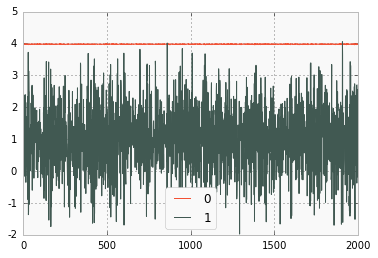

In [92]:
pd.DataFrame(trace.get_values('ap_mean_prior')).plot()

In [93]:
df.groupby('product_category_accessories')['log_price'].mean()

product_category_accessories
0    3.959743
1    4.052874
Name: log_price, dtype: float64

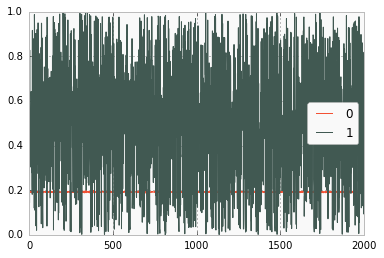

In [90]:
pd.DataFrame(trace.get_values('prior_accessories')).plot()

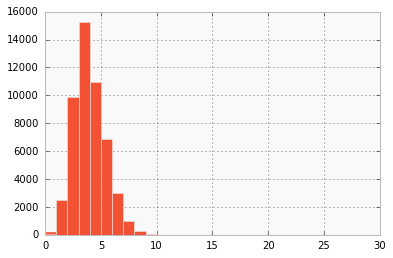

In [72]:
%matplotlib inline
df.log_price.hist(bins = [j for j in range(30)])

In [68]:
pm.Lognormal?